In [1]:
#Rohrmeier, M. (2020). Towards a formalization of musical rhythm. International Society for Music Information Retrieval.

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import librosa
from librosa import display
import librosa.display
from iteration_utilities import deepflatten #flatten nested lists
from fractions import Fraction

import pretty_midi

import fluidsynth
import soundfile as sf
import music21
from music21 import *
import itertools
import random
import mchmm #for Markov models

import nltk #for NLP

# Global Constants

In [245]:
UNIT = 1 #We express duration as fractions of a whole note. Use UNIT = 1/4 to express durations as fractions of quarter-notes

# Notation and playback

In [246]:
def play(score):
    #Shortcut to play a music21 stream
    midi.realtime.StreamPlayer(score).play()
    
def percussion_hit(duration, pitch = "C4"):
    #Create Note object for percussion hits
    return note.Note(pitch, quarterLength = duration*(4*UNIT))

def create_percussion(time_sig = None):
    #Initialize a percussion stream with Woodblock timbre
    #If time signature is None, no measure splits
    if time_sig == None:
        drumPart = stream.Measure()
    else:
        drumPart = stream.Stream()
        drumPart.timeSignature = meter.TimeSignature(time_sig)
    
    drumPart.insert(0, instrument.Woodblock())
    return drumPart

def append_event(duration, original_stream):
    #Append a rhythmical event of given duration to the given stream
    new_stream = original_stream
    new_stream.append(percussion_hit(duration))
    return new_stream

def append_rest(duration, original_stream):
    #Append a rhythmical event of given duration to the given stream
    new_stream = original_stream
    new_stream.append(note.Rest(quarterLength = duration*(4*UNIT)))
    return new_stream

def rhythm_from_sequence(durations, time_sig = None):
    #Generate rhythmic stream from a list of durations
    rhythm = create_percussion(time_sig = time_sig)
    for dur in durations:
        if type(dur) == str:
            rhythm = append_rest(float(Fraction(dur)), rhythm)
        else:
            rhythm = append_event(dur, rhythm) 
    return rhythm



# Rhythmic category class

In [247]:
class rhythmic_category:
    def __init__(self, upbeat, body, tail):
        
        #Parameters
        self.upbeat = upbeat
        self.body = body
        self.tail = tail
        self.parameters = [upbeat, body, tail]
        
    #Rule applications
    def split(self, ratio = 1/2, right_child_upbeat = 0):
        #SPLIT operation on parent metrical category, based on ratio = left_child_body/parent.body. 
        left_child_body = self.body*ratio
        right_child_body = self.body-left_child_body
    
        left_child_cat = rhythmic_category(self.upbeat, left_child_body, - right_child_upbeat)
        right_child_cat = rhythmic_category(right_child_upbeat, right_child_body, self.tail)
    
        return list(deepflatten([left_child_cat.timesteal(), right_child_cat.timesteal()]))
    
    def prepare(self):
        #UPBEAT rule (simplified, no upbeat_of_upbeat)
        if self.upbeat > 0:
            left_child_cat = rhythmic_category(0, self.upbeat, 0)
            right_child_cat = rhythmic_category(0, self.body, self.tail)
    
            return list(deepflatten([left_child_cat.timesteal(),  right_child_cat.timesteal()]))
        else:
            return [self]
        
    def e_shift(self):
        #ANTICIPATE rule
        return [rhythmic_category(0, self.body, self.upbeat+self.tail)]
    
    def l_shift(self):
        #DELAY rule
        return [rhythmic_category(self.upbeat + self.tail, self.body, 0)]
    
    def timesteal(self):
        #TIMESTEALING. We apply it automatically to reduce timestolen rhythmic values as soon as they are generated
        new_upbeat = self.upbeat
        new_tail = self.tail
        timestolen_body = self.body
        if self.upbeat < 0:
            new_upbeat = 0
            timestolen_body += self.upbeat
        if self.tail < 0:
            new_tail = 0
            timestolen_body += self.tail
        return [rhythmic_category(new_upbeat, timestolen_body, new_tail)]
    
    def attach_tail(self):
        #Attach tail to body
        #To be used if tail >0
        return [rhythmic_category(self.upbeat, self.body+self.tail, 0)]

    
    def get_terminals(self):
    #Recursively get terminal durations from metrical categories. Can accept 
    #If there is negative head or tail, interpret as timestealing. If there is positive head, interpret as preparation. If there is positive tail, interpret as a time-thief.
    
        if (self.upbeat == 0) and (self.tail == 0):
            return [self.body]
        elif (self.upbeat < 0) | (self.tail < 0):
            return  list(deepflatten([x.get_terminals() for x in self.timesteal()]))
        elif self.tail > 0:
            return  list(deepflatten([x.get_terminals() for x in self.attach_tail()]))
        elif self.upbeat > 0:
            return list(deepflatten([x.get_terminals() for x in self.prepare()]))
    
        
        

# Generation

In [256]:
def rule(rule_type, p1 = None, p2 = None):
    #Returns dictionary specifying a rule with its parameters
    
    rule_def = {'type': rule_type}
    
    if p1 != None:
        rule_def['p1'] = p1
    if p2 != None:
        rule_def['p2'] = p2
    
    return rule_def
    

def generate_hierarchical_rhythm(tree, starting_symbol, preterminal_string = []):
    #Recursively generate rhythm from a hierarchy of rule applications
    
    if len(tree) == 0:
        return preterminal_string + [starting_symbol]
    else:
        rule = tree[0]
        if rule['type'] == 'split':
            children = starting_symbol.split(ratio = rule['p1'], right_child_upbeat = rule['p2'])
        elif rule['type'] == 'prepare':
            children = starting_symbol.prepare()
        elif rule['type'] == 'anticipate':
            children = starting_symbol.e_shift()
        elif rule['type'] == 'delay':
            children = starting_symbol.l_shift()
            
               
        for child_n in range(len(children)):
            preterminal_string = generate_hierarchical_rhythm(tree[child_n+1], children[child_n], preterminal_string = preterminal_string)
                
    
        return preterminal_string
    

def get_terminal_durations(rhythmic_categories):
    #Turns list of pre-terminal categories in list of terminal durations
    return list(deepflatten([x.get_terminals() for x in rhythmic_categories]))
    

In [258]:
#Define start symbol
S = rhythmic_category(0, 2, 0)

#Define derivation: each node is in the form [rule('ruletype', parameter1, parameter2), [child_node1], [child_node2]]
k = [rule('split', 1/2, 0), [rule('split', 1/2, 0), [rule('split', 1/2, 1/16), [], []], []], [rule('split', 1/2, 1/8), [], [rule('anticipate'), []]]]

generated_rhythm = rhythm_from_sequence(get_terminal_durations(generate_hierarchical_rhythm(k, S, preterminal_string = [])), time_sig = '4/4')

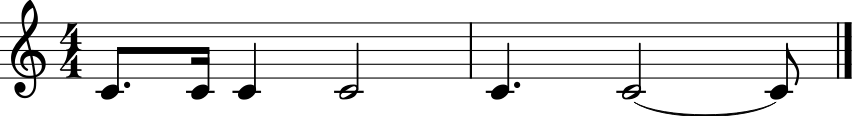

In [259]:
generated_rhythm.show()

In [254]:
play(generated_rhythm)